In [9]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

print(tf.__version__)

2.4.1


In [10]:
#Check if GPU is available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [11]:

CLASSES=["fabric", "foliage", "glass", "leather", "metal", "paper", "plastic", "stone", "water", "wood"]

##  Dataset Preparation

Split the dataset ....

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

# prefetch the dataset
#https://www.tensorflow.org/tutorials/load_data/images
def configure_for_performance(ds,batch_size):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds



def getFMDdataset(image_dir,batch_size=8,img_size=(224,224)):
    CLASSES=["fabric", "foliage", "glass", "leather", "metal", "paper", "plastic", "stone", "water", "wood"]


    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(image_dir,
                                                                class_names=CLASSES,
                                                                shuffle=True,
                                                                batch_size=batch_size,
                                                                image_size=img_size,
                                                                seed=0,
                                                                validation_split=0.2,
                                                                subset="training",
                                                                interpolation='lanczos3',
                                                                #crop_to_aspect_ratio=True,
                                                               )
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory( image_dir,
                                                                class_names=CLASSES,
                                                                shuffle=True,
                                                                batch_size=batch_size,
                                                                image_size=img_size,
                                                                seed=0,
                                                                validation_split=0.2,
                                                                subset="validation",
                                                                interpolation='lanczos3',
                                                                #crop_to_aspect_ratio=True,
                                                               )
    train_dataset=configure_for_performance(train_dataset,batch_size)
    val_dataset=configure_for_performance(val_dataset,batch_size)

    return train_dataset,val_dataset

In [13]:

train_dataset,val_dataset= getFMDdataset("../dataset/FMD/image",8,(224,224))

Found 1000 files belonging to 10 classes.
Using 800 files for training.
Found 1000 files belonging to 10 classes.
Using 200 files for validation.


2021-11-03 20:33:39.572732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 20:33:39.573220: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-03 20:33:39.573288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 20:33:39.573736: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:02:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 

In [14]:
train_dataset

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

2021-11-03 20:33:41.379870: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-03 20:33:41.398680: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3099995000 Hz


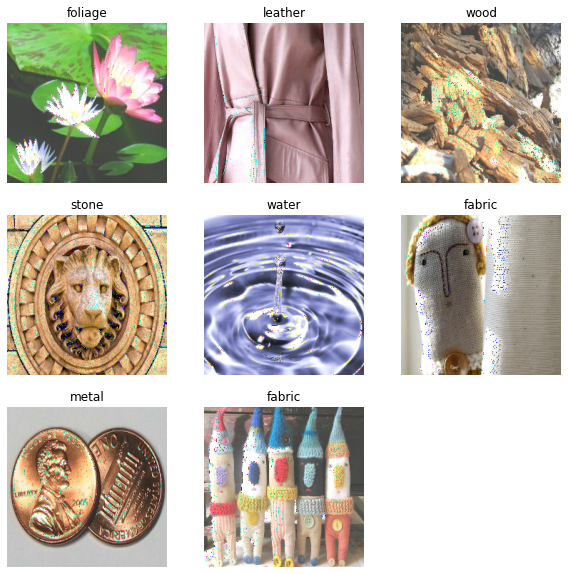

In [15]:
#visualize the dataset to ensure correctness
class_names = CLASSES
batch_size= 8
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(batch_size):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model


In [115]:
def resnet50(lr):
    base_model=tf.keras.applications.ResNet50(
        include_top=False, weights='imagenet')
    base_model.trainable=False
    base_model.training=False
    base_model._name ='base_model'
    model = tf.keras.Sequential([
        tf.keras.layers.Lambda(tf.keras.applications.resnet.preprocess_input, name='preprocessing', input_shape=(224, 224, 3)),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10,activation="softmax")    
    ])
    model.summary()

    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy")])

    return model

model=resnet50(0.001)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing (Lambda)       (None, 224, 224, 3)       0         
_________________________________________________________________
base_model (Functional)      (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                20490     
Total params: 23,616,394
Trainable params: 24,586
Non-trainable params: 23,591,808
____________________________________

In [116]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
EARLY_STOP_PATIENCE=10
early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
model_cp = ModelCheckpoint(filepath = './weights/baseline_best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [117]:
EPOCHS=30

history = model.fit(
        train_dataset,
        epochs = EPOCHS,
        validation_data=val_dataset,
        callbacks=[model_cp, early_stopper],
        use_multiprocessing=True,
        workers=4
)

Epoch 1/30
100/100 [==============================] - 4s 24ms/step - loss: 2.5387 - accuracy: 0.2915 - top-5-accuracy: 0.5135 - val_loss: 0.8632 - val_accuracy: 0.7200 - val_top-5-accuracy: 0.5400
Epoch 2/30
100/100 [==============================] - 2s 20ms/step - loss: 0.8448 - accuracy: 0.7228 - top-5-accuracy: 0.4984 - val_loss: 0.7363 - val_accuracy: 0.7900 - val_top-5-accuracy: 0.5650
Epoch 3/30
100/100 [==============================] - 2s 19ms/step - loss: 0.5821 - accuracy: 0.7958 - top-5-accuracy: 0.5080 - val_loss: 0.7504 - val_accuracy: 0.7750 - val_top-5-accuracy: 0.5250
Epoch 4/30
100/100 [==============================] - 2s 20ms/step - loss: 0.3990 - accuracy: 0.8580 - top-5-accuracy: 0.4653 - val_loss: 0.7697 - val_accuracy: 0.7850 - val_top-5-accuracy: 0.5100
Epoch 5/30
100/100 [==============================] - 2s 21ms/step - loss: 0.2399 - accuracy: 0.9184 - top-5-accuracy: 0.5377 - val_loss: 0.7618 - val_accuracy: 0.7700 - val_top-5-accuracy: 0.5000
Epoch 6/30
100/

## Visualize result

ROC_AUC score : 0.97 

              precision    recall  f1-score   support

      fabric       0.86      0.69      0.77        26
     foliage       0.86      0.86      0.86        21
       glass       0.80      0.76      0.78        21
     leather       0.71      0.79      0.75        19
       metal       0.59      0.71      0.65        14
       paper       0.72      0.86      0.78        21
     plastic       0.70      0.70      0.70        20
       stone       0.82      0.86      0.84        21
       water       0.90      0.90      0.90        21
        wood       0.92      0.69      0.79        16

    accuracy                           0.79       200
   macro avg       0.79      0.78      0.78       200
weighted avg       0.79      0.79      0.79       200



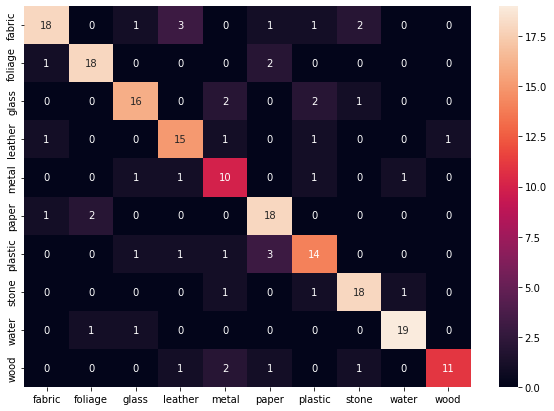

In [118]:

def print_evaluation_result(model,val_dataset,classes):
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import classification_report

    predictions_one_hot = np.array([])
    labels_one_hot =  np.array([])
    predictions = np.array([])
    labels =  np.array([])
    for x, y in val_dataset:
        categorical_labels = np.identity(10)[y.numpy()]
        prediction= model.predict(x)

        predictions_one_hot = np.concatenate([predictions_one_hot,prediction],axis=None)
        predictions = np.concatenate([predictions, np.argmax(prediction, axis=-1)],axis=None)

        labels_one_hot = np.concatenate([labels_one_hot, categorical_labels],axis=None)
        labels = np.concatenate([labels, y],axis=None)
            
    print(f'ROC_AUC score : {round(roc_auc_score(labels_one_hot, predictions_one_hot, average="weighted", multi_class="ovr"),2)} \n')
    print(classification_report(labels, predictions, target_names=classes))
    confusion_matrix= tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

    df_cm = pd.DataFrame(confusion_matrix, index = classes,
                      columns = classes)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
print_evaluation_result(model,val_dataset,CLASSES)

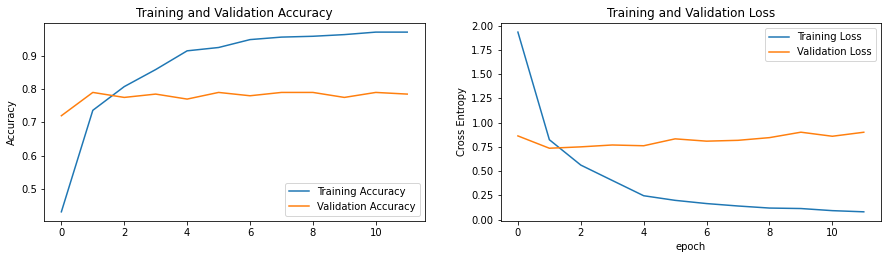

In [119]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning 

In [120]:

def unfreeze_model(model):
    model.layers[1].trainable=True

    fine_tune_at = len(model.layers[1].layers)-10

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in model.layers[1].layers[:fine_tune_at]:
        layer.trainable =  False

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy',  tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy")])

    model.summary()


unfreeze_model(model)


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing (Lambda)       (None, 224, 224, 3)       0         
_________________________________________________________________
base_model (Functional)      (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                20490     
Total params: 23,616,394
Trainable params: 4,490,250
Non-trainable params: 19,126,144
_________________________________

In [121]:
fine_tune_epochs = 30
initial_epochs=history.epoch[-1]
total_epochs = initial_epochs  + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=initial_epochs,
                         validation_data=val_dataset)

Epoch 12/41
100/100 [==============================] - 4s 27ms/step - loss: 0.1335 - accuracy: 0.9564 - top-5-accuracy: 0.4473 - val_loss: 1.0736 - val_accuracy: 0.7800 - val_top-5-accuracy: 0.4350
Epoch 13/41
100/100 [==============================] - 2s 22ms/step - loss: 0.0762 - accuracy: 0.9743 - top-5-accuracy: 0.4583 - val_loss: 1.0667 - val_accuracy: 0.7900 - val_top-5-accuracy: 0.4900
Epoch 14/41
100/100 [==============================] - 2s 22ms/step - loss: 0.0327 - accuracy: 0.9913 - top-5-accuracy: 0.4782 - val_loss: 0.9837 - val_accuracy: 0.8000 - val_top-5-accuracy: 0.5200
Epoch 15/41
100/100 [==============================] - 2s 22ms/step - loss: 0.0316 - accuracy: 0.9845 - top-5-accuracy: 0.4453 - val_loss: 1.0980 - val_accuracy: 0.7900 - val_top-5-accuracy: 0.4950
Epoch 16/41
100/100 [==============================] - 2s 22ms/step - loss: 0.0233 - accuracy: 0.9956 - top-5-accuracy: 0.4604 - val_loss: 0.9871 - val_accuracy: 0.7850 - val_top-5-accuracy: 0.5550
Epoch 17/4

In [122]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

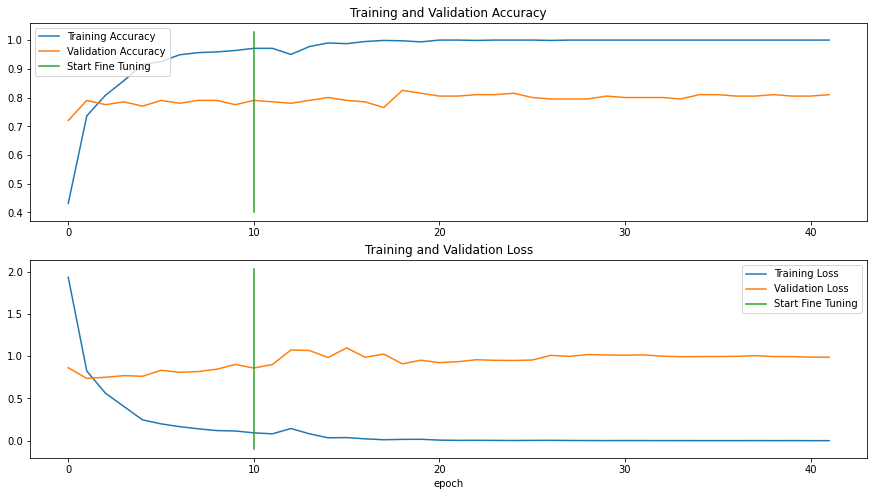

In [123]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()